<a href="https://colab.research.google.com/github/JasonLo/demo/blob/master/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow O-to-P model demo

Three steps:
1. Preparation
2. Modeling
3. Visualisation

# Preparation

## Ingest/tidying data

Download file from my repository

You can use any bash command with a **!**

Let's check demo folder is already downloaded to my virtual disk

In [30]:
!git clone https://github.com/JasonLo/demo.git
!ls

fatal: destination path 'demo' already exists and is not an empty directory.
demo  sample_data


Using pandas to tidy data 


In [0]:
import pandas as pd

Items.csv is from English lexicon project https://elexicon.wustl.edu/index.html
- Items are all one syllable word
- With some extra columns, we are going to use:
    - "Word" = the word itself
    - "Pron" = pronunciation
    - "SUBTLWF" = Subtitle frequency
    - "Age_Of_Acquisition" = Age of acquisition

Let's read this file disk, and see the variable names

In [32]:
raw = pd.read_csv('demo/Items.csv', index_col=None, na_values='#', thousands=',')
raw.columns

Index(['Word', 'Length', 'SUBTLWF', 'Ortho_N', 'Concreteness_Rating',
       'Semantic_Neighbors', 'Semantic_Diversity', 'Age_Of_Acquisition',
       'Pron', 'NSyll', 'I_NMG_Mean_RT', 'I_NMG_Zscore',
       'I_NMG_Mean_Accuracy'],
      dtype='object')

Select useful columns, and check some examples


In [33]:
df = raw[['Word', 'Pron', 'SUBTLWF', 'Age_Of_Acquisition']]
df = df.rename(columns={'Word':'word', 'Pron': 'p', 'SUBTLWF':'wf', 'Age_Of_Acquisition':'aoa'})
df.head

<bound method NDFrame.head of         word        p        wf    aoa
0          a       "e  20415.27  2.893
1        Abe      "eb       NaN    NaN
2        ace      "es     14.73  8.830
3       ache      "ek      2.49  5.790
4      ached     "ekt      0.31  5.790
...      ...      ...       ...    ...
9515    zips    z"Ips      0.33    NaN
9516  zonked   z"ANkt      0.25    NaN
9517  zoomed    z"umd      0.18    NaN
9518    zoos     z"uz      0.76    NaN
9519  ZOUNDS  z"aUndz      0.10    NaN

[9520 rows x 4 columns]>

Some words don't have word frequncy info or age of acquisition info, just throw them away... Also, letters are cased, covert all to lower case 

In [34]:
df = df.dropna()
df = df.reset_index(drop=True)
df['index'] = df.index
df.head

<bound method NDFrame.head of        word      p        wf    aoa  index
0         a     "e  20415.27  2.893      0
1       ace    "es     14.73  8.830      1
2      ache    "ek      2.49  5.790      2
3     ached   "ekt      0.31  5.790      3
4     aches   "eks      1.51  5.790      4
...     ...    ...       ...    ...    ...
5536  zoned  z"ond      0.35  8.790   5536
5537  zones  z"onz      1.76  8.790   5537
5538    zoo    z"u     13.65  3.750   5538
5539   zoom   z"um      3.55  8.570   5539
5540  zooms  z"umz      0.06  8.570   5540

[5541 rows x 5 columns]>

Good enough for demo purpose...

## Representation encoding
- In O: 
    - letter by letter one-hot, slot based
- In P: source file pronounciation is encoded in sampa: http://www.phon.ucl.ac.uk/home/sampa
    - For simplicity sake, just use the same slot based one-hot encoding


In [35]:
%tensorflow_version 2.x
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Extract words for easy access
words = list(df.word)
pron = list(df.p)

# Build letter tokenizer based on words
token_o = Tokenizer(char_level=True)
token_o.fit_on_texts(words)
print('Letter dictionary:', token_o.word_index)

token_p = Tokenizer(filters='', char_level=True, lower=False) # This is quite wrong... Should hand craft a dictionary instead.
token_p.fit_on_texts(pron)
print('(Wrong) SAMPA dictionary:', token_p.word_index)

# Use number to represent letter
word_seq = token_o.texts_to_sequences(words)
pron_seq = token_p.texts_to_sequences(pron)

# Since each word have different length, we need to pad it to keep the input consistent in shape
word_padseq = pad_sequences(word_seq)
pron_padseq = pad_sequences(pron_seq)

# One-hot encoding
ort_adult = to_categorical(word_padseq)
pho_adult = to_categorical(pron_padseq)

# Dimensions
print(f'Orthographic representation dimensions: {ort_adult.shape}')
print(f'Phonological representation dimensions: {pho_adult.shape}')

Letter dictionary: {'e': 1, 's': 2, 'a': 3, 'r': 4, 't': 5, 'o': 6, 'd': 7, 'l': 8, 'i': 9, 'n': 10, 'h': 11, 'c': 12, 'p': 13, 'u': 14, 'g': 15, 'm': 16, 'b': 17, 'k': 18, 'w': 19, 'f': 20, 'v': 21, 'y': 22, 'z': 23, 'q': 24, 'j': 25, 'x': 26}
(Wrong) SAMPA dictionary: {'"': 1, 's': 2, 't': 3, 'r': 4, 'l': 5, 'd': 6, 'k': 7, 'a': 8, 'I': 9, 'z': 10, 'p': 11, 'n': 12, 'm': 13, 'b': 14, 'f': 15, 'e': 16, 'S': 17, 'E': 18, 'V': 19, 'O': 20, 'i': 21, 'A': 22, 'g': 23, 'o': 24, 'w': 25, 'u': 26, 'h': 27, 'U': 28, '`': 29, 'v': 30, '3': 31, 'Z': 32, 'N': 33, 'T': 34, '@': 35, 'j': 36, 'D': 37, 'R': 38, 'H': 39}
Orthographic representation dimensions: (5541, 9, 27)
Phonological representation dimensions: (5541, 9, 40)


We can combine 2nd and 3rd dimension

In [0]:
import numpy as np
ort_adult = ort_adult.reshape(5541, 9*27)
pho_adult = pho_adult.reshape(5541, 9*40)

Print example for illustration: Orthographic representation

In [37]:
wid = 100  # Select a word (anything less then )
print(f'The word is: {words[wid]}')
print(f'Using number to represent a letter, it becomes: {word_seq[wid]}')
print(f'Padding it to maximum length of word (9): {word_padseq[wid]}')
print(f'One-hot encoding: {ort_adult[wid]}')

The word is: banked
Using number to represent a letter, it becomes: [17, 3, 10, 18, 1, 7]
Padding it to maximum length of word (9): [ 0  0  0 17  3 10 18  1  7]
One-hot encoding: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


Phonological representation sample

In [38]:
print('\n')
print(f'The word pronounciation in SAMPA is: {pron[wid]}')
print(f'Using number to represent pronounciation: {pron_seq[wid]}')
print(f'Padding it to maximum length of pronounciation (9): {pron_padseq[wid]}')
print(f'One-hot encoding: {pho_adult[wid]}')



The word pronounciation in SAMPA is: b"aNkt
Using number to represent pronounciation: [14, 1, 8, 33, 7, 3]
Padding it to maximum length of pronounciation (9): [ 0  0  0 14  1  8 33  7  3]
One-hot encoding: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

**How many input do we have in O?**
- [ ] 9
- [ ] 27 * 9 = 243
- [ ] 26
- [ ] 26 * 9 = 234

## Function for decoding
We may want to reverse an encoded (i.e. decode) representation later

In [39]:
def rev_representation(mat, tokenizer, original_shape):
    """This function can decode representation"""
    boo = np.argmax(mat.reshape(original_shape), axis=1)
    return tokenizer.sequences_to_texts(boo.reshape(1,9))

print(f'For example: the word {df.word[100]}:\n')
print(f'The orthographic representation is: \n {ort_adult[100]}\n')
print(f'Reversing it using rev_representation() becomes: {rev_representation(ort_adult[100], token_o, (9, 27))}\n')
print(f'Similarly, reversing phonological representation: {rev_representation(pho_adult[100], token_p, (9, 40))}')

For example: the word banked:

The orthographic representation is: 
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]

Reversing it using rev_representation() becomes: ['b a n k e d']

Similarly, reversing phonological representation: ['b " a N k t']


## Create child dataset using AOA
*   Let's examing aoa distribution a bit

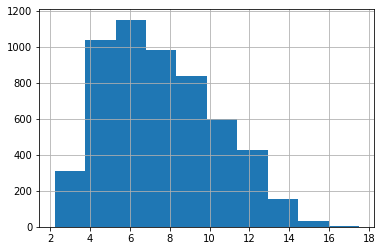

In [40]:
df.aoa.hist()

Split at 6 maybe... near grade one.
You can choose any split you like.
We can compare results later 

1944 words remaining


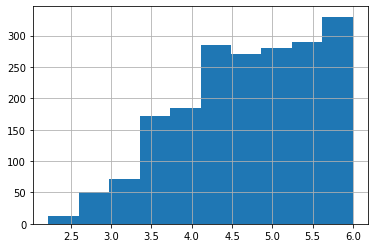

In [41]:
df_child = df[df.aoa<=6]
df_child.aoa.hist()
print(f'{len(df_child)} words remaining')

Subset it from adult data file

In [42]:
ort_child = ort_adult[df_child.index]
pho_child = pho_adult[df_child.index]

print(f'The shape of input ort: {ort_child.shape}')
print(f'The shape of output pho: {pho_child.shape}')

The shape of input ort: (1944, 243)
The shape of output pho: (1944, 360)


## Lookup Strain set in this representation

In [43]:
strain_raw = pd.read_csv('demo/df_strain_demo.csv')
strain_raw.head

<bound method NDFrame.head of       word frequency pho_consistency imageability
0     ball        HF             INC           HI
1     bank        HF             CON           HI
2    beach        HF             CON           HI
3     beak        LF             INC           HI
4    beard        LF             INC           HI
..     ...       ...             ...          ...
155   wool        LF             INC           HI
156   worm        LF             INC           HI
157  worth        HF             INC           LI
158  wrong        HF             CON           LI
159   zone        LF             INC           LI

[160 rows x 4 columns]>

Find strain items in df and then merge, get original df index for slicing representations

In [44]:
strain = pd.merge(df, strain_raw, on='word')
strain

,word,p,wf,aoa,index,frequency,pho_consistency,imageability
0,ball,"b""Ol",104.96,2.900,88,HF,INC,HI
1,bank,"b""aNk",84.98,6.440,99,HF,CON,HI
2,beach,"b""itS",56.63,4.800,136,HF,CON,HI
3,beak,"b""ik",2.10,5.420,139,LF,INC,HI
4,beard,"b""Ird",12.61,4.840,145,LF,INC,HI
...,...,...,...,...,...,...,...,...
155,wool,"w""Ul",3.16,8.060,5434,LF,INC,HI
156,worm,"w""3`m",10.12,3.890,5443,LF,INC,HI
157,worth,"w""3`T",109.20,7.085,5449,HF,INC,LI
158,wrong,"r""ON",523.10,4.220,5479,HF,CON,LI


Id of four conditions

In [0]:
hf_con_id = strain.loc[(strain.frequency=='HF') & (strain.pho_consistency == 'CON'),'index'].to_list()
lf_con_id = strain.loc[(strain.frequency=='LF') & (strain.pho_consistency == 'CON'),'index'].to_list()
hf_inc_id = strain.loc[(strain.frequency=='HF') & (strain.pho_consistency == 'INC'),'index'].to_list()
lf_inc_id = strain.loc[(strain.frequency=='LF') & (strain.pho_consistency == 'INC'),'index'].to_list()

Get representations

In [0]:
ort_hf_con = ort_adult[hf_con_id]
ort_hf_inc = ort_adult[hf_inc_id]
ort_lf_con = ort_adult[lf_con_id]
ort_lf_inc = ort_adult[lf_inc_id]

pho_hf_con = pho_adult[hf_con_id]
pho_hf_inc = pho_adult[hf_inc_id]
pho_lf_con = pho_adult[lf_con_id]
pho_lf_inc = pho_adult[lf_inc_id]

## Just in case... check a sample in each condition (Skip)

In [47]:
# Item no. 10 of each condition
i = 10

print(rev_representation(ort_hf_con[i], token_o, (9, 27)))
print(rev_representation(ort_hf_inc[i], token_o, (9, 27)))
print(rev_representation(ort_lf_con[i], token_o, (9, 27)))
print(rev_representation(ort_lf_inc[i], token_o, (9, 27)))

print(rev_representation(pho_hf_con[i], token_p, (9, 40)))
print(rev_representation(pho_hf_inc[i], token_p, (9, 40)))
print(rev_representation(pho_lf_con[i], token_p, (9, 40)))
print(rev_representation(pho_lf_inc[i], token_p, (9, 40)))

['d e e p']
['d o g']
['d i m e']
['f o e']
['d " i p']
['d " O g']
['d " a I m']
['f " o']


In [0]:
strain.loc[strain.word == 'deep',:]

,word,p,wf,aoa,index,frequency,pho_consistency,imageability
39,deep,"d""ip",76.39,5.47,1089,HF,CON,LI


In [0]:
strain.loc[strain.word == 'dog',:]

,word,p,wf,aoa,index,frequency,pho_consistency,imageability
41,dog,"d""Og",192.84,2.8,1156,HF,INC,HI


In [0]:
strain.loc[strain.word == 'dime',:]

,word,p,wf,aoa,index,frequency,pho_consistency,imageability
40,dime,"d""aIm",12.06,5.74,1122,LF,CON,HI


In [0]:
strain.loc[strain.word == 'foe',:]

,word,p,wf,aoa,index,frequency,pho_consistency,imageability
51,foe,"f""o",1.84,9.95,1583,LF,INC,LI


# Modeling
- Kind of easier than preparation...

## Building model

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Dense(50, activation='sigmoid', input_shape=(243,)))
model.add(Dense(9*40, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
            optimizer=Adam(0.1),
            metrics=['binary_accuracy', 'mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                12200     
_________________________________________________________________
dense_1 (Dense)              (None, 360)               18360     
Total params: 30,560
Trainable params: 30,560
Non-trainable params: 0
_________________________________________________________________


## Training model

In [49]:
from tensorflow.keras.callbacks import ModelCheckpoint
                            
hist = model.fit(x = ort_adult, 
                 y = pho_adult, 
                 batch_size = 128, 
                 epochs = 10, 
                 sample_weight = np.log(df.wf + 2))   # This sample_weight is for weighting the loss function

  ...
    to  
  ['...']
Train on 5541 samples
Epoch 1/10
5541/5541 [==============================] - 0s 30us/sample - loss: 0.0436 - binary_accuracy: 0.9919 - mse: 0.0062
Epoch 2/10
5541/5541 [==============================] - 0s 28us/sample - loss: 0.0408 - binary_accuracy: 0.9924 - mse: 0.0059
Epoch 3/10
5541/5541 [==============================] - 0s 27us/sample - loss: 0.0385 - binary_accuracy: 0.9927 - mse: 0.0056
Epoch 4/10
5541/5541 [==============================] - 0s 29us/sample - loss: 0.0362 - binary_accuracy: 0.9931 - mse: 0.0053
Epoch 5/10
5541/5541 [==============================] - 0s 28us/sample - loss: 0.0346 - binary_accuracy: 0.9933 - mse: 0.0051
Epoch 6/10
5541/5541 [==============================] - 0s 30us/sample - loss: 0.0339 - binary_accuracy: 0.9934 - mse: 0.0050
Epoch 7/10
5541/5541 [==============================] - 0s 24us/sample - loss: 0.0320 - binary_accuracy: 0.9937 - mse: 0.0048
Epoch 8/10
5541/5541 [==============================] - 0s 24us/sample 

# Visualize results


In [50]:
import altair as alt

# Create training history dataframe
history = pd.DataFrame(hist.history)
history['epoch'] = history.index

# Select a metric to plot
plot_metic = 'loss'
plot_data = history[['epoch', plot_metic]]
alt.Chart(plot_data).mark_line().encode(
    x='epoch',
    y=plot_metic,
    tooltip=['epoch', plot_metic]
).properties(title=f'Training history ({plot_metic})')

alt.Chart(...)

## Evaluate test set

In [51]:
# Put test set in a list of tuple (<condition>, <ortho>, <pho>)
testsets = [('hf_con', ort_hf_con, pho_hf_con),
            ('hf_inc', ort_hf_inc, pho_hf_inc),
            ('lf_con', ort_lf_con, pho_lf_con),
            ('lf_inc', ort_lf_inc, pho_lf_inc)]

results = [] 
for testset in testsets:
    name, x, y = testset
    # Evaulate one test set (condition)
    result = model.evaluate(x, y)   # Since model is the trained one, it only record last epoch result...
    results.append([name, result[1], result[2]]) # result 0 = loss, 1 = accuracy, 2 = mse
    
results_df = pd.DataFrame(results, columns=['cond', 'acc', 'mse'])
results_df

40/40 [==============================] - 0s 306us/sample - loss: 0.0140 - binary_accuracy: 0.9944 - mse: 0.0041


,cond,acc,mse
0,hf_con,0.997431,0.002167
1,hf_inc,0.995417,0.003064
2,lf_con,0.996875,0.002439
3,lf_inc,0.994444,0.004122


## Plotting Strain

In [52]:
alt.Chart(results_df).mark_bar().encode(
    x='cond',
    y='mse',
    color=alt.Color('cond'),
    tooltip=['cond', 'acc', 'mse']
).properties(title='Strain results (Error)').interactive()

alt.Chart(...)

## My point is... first model usually won't work well... :P

- [ ] Try swapping training set to "child" data
- [ ] Try to get human Strain pattern by varying model parameters
- [ ] Think about what the psychological meaning in each parameter that you have change